In [135]:
import pandas as pd
import os 
import glob 
import math 
import numpy as np 
from matplotlib import pyplot as plt

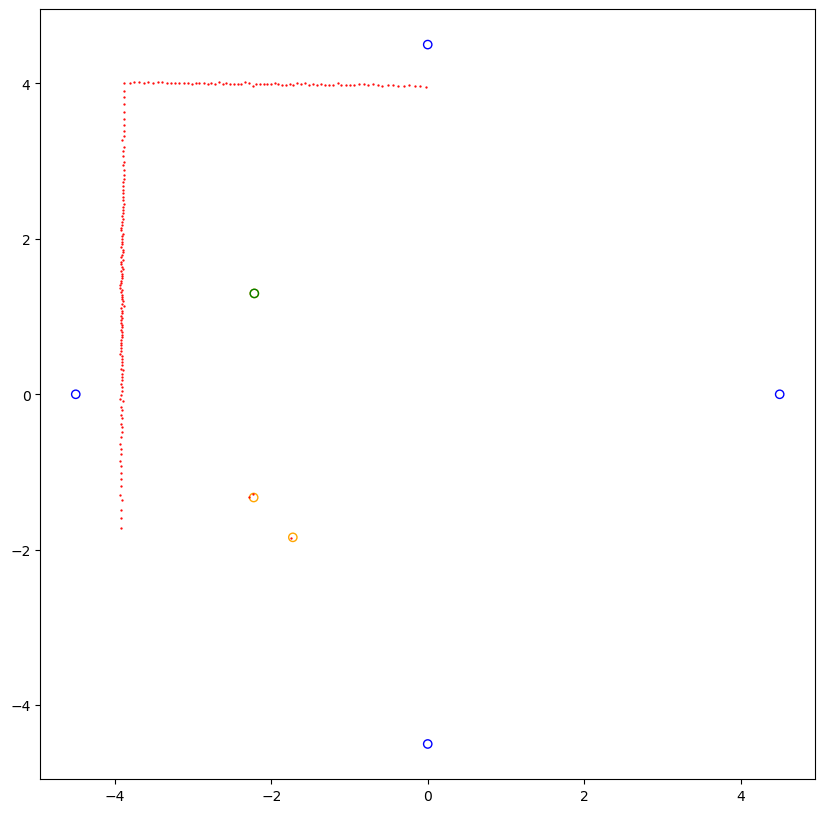

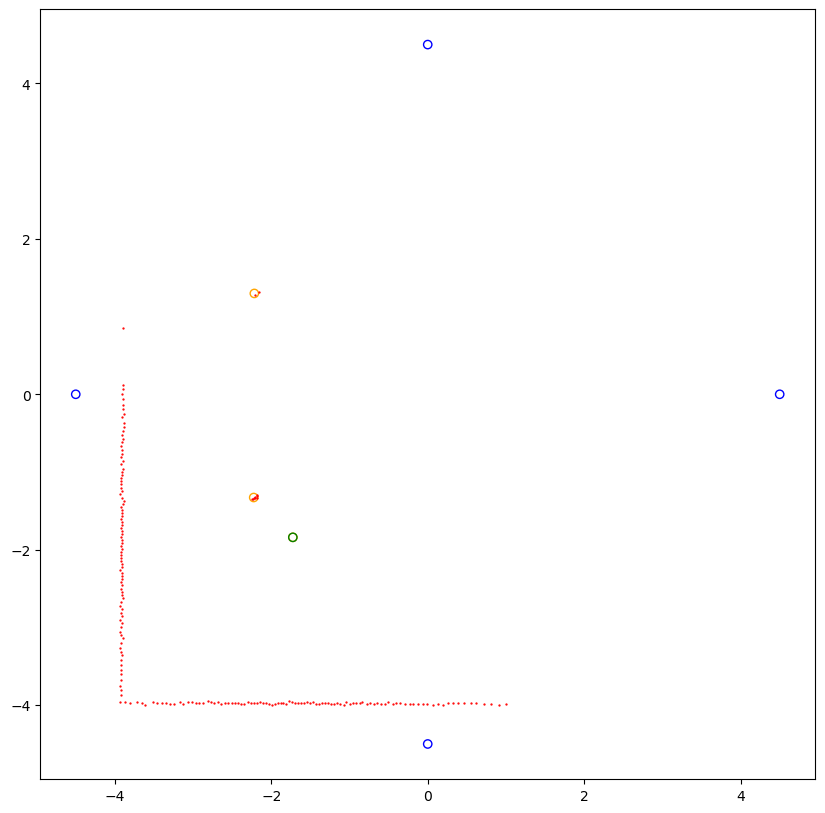

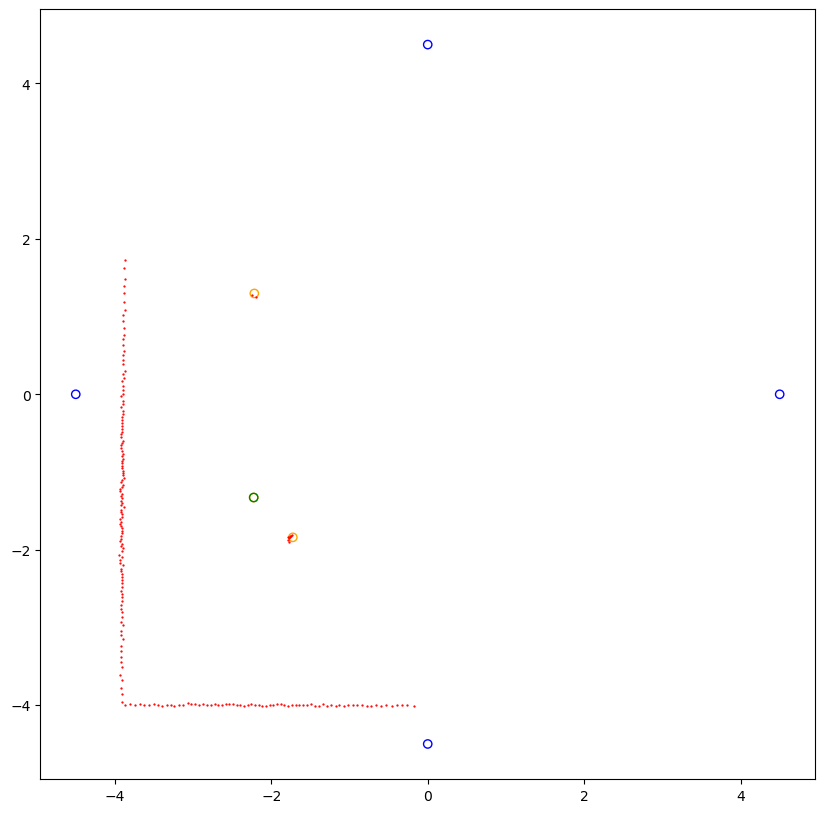

In [137]:
subfolders = [f.name for f in os.scandir('./') if f.is_dir() and f.name[:1] != '.']
for subfolder in subfolders: 
    files = glob.glob(subfolder+'/*.csv')
    for f in files: 
        df = pd.read_csv(f)
    
        # index for line in data frame 
        idx = 53

        # get object names  
        names = [el[1:-1] for el in df['poses'][idx].split('[')[1].split(']')[0].split(', ')]

        # get object positions 
        positions_x = [] 
        positions_y = [] 
        orientations = [] 

        string = df['poses'][idx]

        for i in range(0, len(names)):
            # get position 
            start = string.find('Point')
            stop = string[start:].find(')')
            pose = string[start+6:start+stop].split(', ')
            positions_x.append(float(pose[0][2:]))
            positions_y.append(float(pose[1][2:]))

            # get yaw angle (rotation around x-axis )
            string = string[start+6:]
            start = string.find('Quaternion')
            stop = string[start:].find(')')
            orientation = string[start+11:start+stop].split(', ')

            q_x = float(orientation[0][2:])
            q_y = float(orientation[1][2:])
            q_z = float(orientation[2][2:])
            q_w = float(orientation[3][2:])

            siny_cosp = 2 * (q_w * q_z + q_x * q_y)
            cosy_cosp = 1 - 2 * (q_y * q_y + q_z * q_z)
            orientations.append(np.arctan2(siny_cosp, cosy_cosp))
    
        # get lidar data 
        ld = [float(el) for el in df['scan'][idx].split('ranges=[')[1].split('],')[0].split(',')]
        
        # get object and robot positions from data frame 
        objects_x = [] 
        objects_y = [] 
        robots_x = [] 
        robots_y = [] 
        lidar_x = []
        lidar_y = []
        
        # position of current robot (lidar data)
        r_x = 0 
        r_y = 0 
        
        for i in range(0, len(names)):

            if names[i][:5] == "robot":
                robots_x.append(positions_x[i])
                robots_y.append(positions_y[i])   

                if names[i] == df['robot'][idx]:
                    r_x = positions_x[i]
                    r_y = positions_y[i]
                    angle = orientations[i]

            elif names[i] != "ground_plane": 
                objects_x.append(positions_x[i])
                objects_y.append(positions_y[i])

         # transform lidar data to x, y positions 

        for i in range(0, 360): 
            if not math.isinf(ld[i]):
                lidar_x.append(ld[i] * math.cos(angle + np.deg2rad(i)) + r_x)
                lidar_y.append(ld[i] * math.sin(angle + np.deg2rad(i)) + r_y)
        
        plt.figure(figsize=(10, 10))
        plt.scatter(x=objects_x, y=objects_y, facecolors='none', edgecolors='blue') # objects except ground plane 
        plt.scatter(x=robots_x, y=robots_y, facecolors='none', edgecolors='orange') # robots 
        plt.scatter(r_x, r_y, facecolors='none', edgecolors='green') # robots 
        plt.scatter(lidar_x, lidar_y, s=0.4, color='red') # lidar           